# **Spatial Autocorrelation in Single-Cell Data**
**Author:** [Severin Dicks](https://github.com/Intron7)
**Copyright** [scverse](https://scverse.org)


In this notebook, we explore spatial autocorrelation metrics, specifically **Moran’s I** and **Geary’s C**,  
to assess the spatial organization of gene expression patterns.  

We demonstrate how to compute these metrics using **Squidpy** and **rapids-singlecell**,  
highlighting their application in detecting spatially structured genes within tissue sections.  

Spatial autocorrelation helps reveal biological patterns such as **niche-specific expression**  
and **spatial gradients**, providing insights into tissue architecture.

In [1]:
import squidpy as sq
import rapids_singlecell as rsc
import cupy as cp

/home/intron/micromamba/envs/rapids-24.12/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/home/intron/micromamba/envs/rapids-24.12/lib/python3.12/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/intron/micromamba/envs/rapids-24.12/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


In [15]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
adata = sq.datasets.visium_hne_adata()

### Constructing a Spatial Graph  

Before computing spatial autocorrelation, we first need to build a **spatial neighbors graph**,  
which defines spatial relationships between cells or tissue spots.  

We use **Squidpy** to compute the graph based on spatial coordinates stored in `adata.obsm["spatial"]`

In [4]:
%%time
sq.gr.spatial_neighbors(adata)

CPU times: user 6 ms, sys: 89 μs, total: 6.08 ms
Wall time: 5.42 ms


In [5]:
genes = adata.var_names

## Moran's I
To assess spatial structure in gene expression, we compute **spatial autocorrelation**,  
which measures how gene expression levels are spatially distributed across tissue sections.  

In [19]:
%%time
rsc.gr.spatial_autocorr(adata, mode="moran", genes=genes, n_perms=100, use_sparse=False)

CPU times: user 396 ms, sys: 142 ms, total: 538 ms
Wall time: 533 ms


In [7]:
adata.uns["moranI"]

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Nrgn,0.874753,0.000000,0.000131,0.000000,0.009901,0.000323,0.000000,0.000000,0.016667
Mbp,0.868723,0.000000,0.000131,0.000000,0.009901,0.000333,0.000000,0.000000,0.016667
Camk2n1,0.866545,0.000000,0.000131,0.000000,0.009901,0.000296,0.000000,0.000000,0.016667
Slc17a7,0.861761,0.000000,0.000131,0.000000,0.009901,0.000300,0.000000,0.000000,0.016667
Ttr,0.841988,0.000000,0.000131,0.000000,0.009901,0.000328,0.000000,0.000000,0.016667
...,...,...,...,...,...,...,...,...,...
Slc9a8,-0.026960,0.010027,0.000131,0.000327,0.009901,0.000066,0.017979,0.000610,0.016667
Pramef8,-0.028659,0.006681,0.000131,0.000011,0.009901,0.000043,0.012348,0.000024,0.016667
Klf12,-0.028764,0.006512,0.000131,0.000087,0.009901,0.000061,0.012052,0.000171,0.016667
Gart,-0.028859,0.006361,0.000131,0.000384,0.009901,0.000077,0.011784,0.000713,0.016667


## Geary's C

In addition to **Moran’s I**, we compute **Geary’s C**, another spatial autocorrelation metric.  
While Moran’s I captures **global spatial structure**, **Geary’s C** is more sensitive to **local differences**,  
highlighting regions with abrupt expression changes.  

`use_sparse=True` Enables sparse computation, preventing full matrix densification.
This optimization is handled efficiently in the GPU kernel, significantly reducing memory usage.
Moran’s I also supports use_sparse=True, allowing for efficient computation on large datasets.

In [21]:
%%time
rsc.gr.spatial_autocorr(adata, mode="geary", genes=genes, n_perms=100, use_sparse=True)

CPU times: user 527 ms, sys: 40 ms, total: 567 ms
Wall time: 562 ms


In [11]:
adata.uns["gearyC"]

,C,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Nrgn,0.126481,0.000000e+00,0.000131,0.000000,0.009901,0.000337,0.000000e+00,0.000000,0.016733
Mbp,0.132854,0.000000e+00,0.000131,0.000000,0.009901,0.000300,0.000000e+00,0.000000,0.016733
Camk2n1,0.135106,0.000000e+00,0.000131,0.000000,0.009901,0.000322,0.000000e+00,0.000000,0.016733
Slc17a7,0.138819,0.000000e+00,0.000131,0.000000,0.009901,0.000322,0.000000e+00,0.000000,0.016733
Ttr,0.156155,0.000000e+00,0.000131,0.000000,0.009901,0.000343,0.000000e+00,0.000000,0.016733
...,...,...,...,...,...,...,...,...,...
AC166344.1,1.079271,2.059686e-12,0.000131,0.421383,0.049505,0.000050,7.064124e-12,0.436020,0.071936
Gm14091,1.083541,1.372236e-13,0.000131,0.424654,0.148515,0.001859,4.932845e-13,0.438104,0.189007
Slc6a5,1.087126,1.265654e-14,0.000131,0.447575,0.405941,0.000377,4.722497e-14,0.455640,0.428381
Soat2,1.093646,1.110223e-16,0.000131,0.436112,0.326733,0.000165,4.432556e-16,0.446482,0.361973


To explore spatial patterns in gene expression, we use **Squidpy’s spatial scatter plot**,  
which overlays expression values onto the spatial coordinates of cells or tissue spots.  

We visualize the expression of **Mbp** (myelin-associated) and **Nrgn** (neuronal marker):  

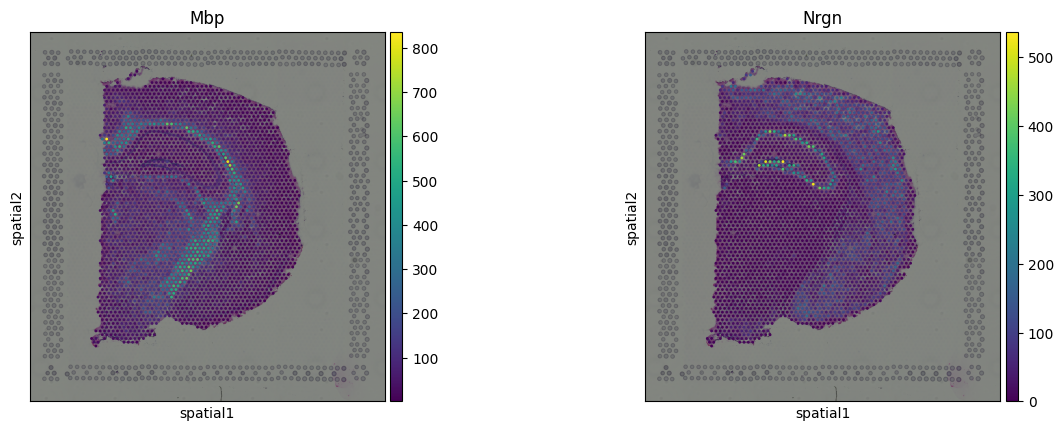

In [22]:
sq.pl.spatial_scatter(adata, color=["Mbp", "Nrgn"])